# Variational Gaussian Regression

In this lab we will implement our own Gaussian Process model using the TensorFlow toolkit!

## Tasks

- Implement a numpy function that evaluates the squared exponential kernel using for loops and use it to check that the tensorflow function provided is correct. 

- Get the GP regression code running on a toy example with a Gaussian likelihood

- Now run the code on traffic count data (the training outputs are integers) and observe what happens. Add a brief text comment highlighting what has gone wrong and why. 

- Implement a periodic kernel to replace the squared exponential kernel and run the regression model with the new kernel. Does the situation improve slightly? 

- Now prove two of the mathematical results in the derivation of the lower bound for a variational Gaussian Process using a Poisson likelihood (non-Gaussian likelihood). 

- Modify the original GP regression code to implement the Poisson likelihood GP and run it on the count data with the squared exponential kernel. 

- Run your Poisson GP with the periodic kernel and comment on the final output. 

In [1]:
# Import statements..

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

dtype = tf.float64
dtype_convert = tf.to_double

np.random.seed(0)

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Squared Exponential Covariance Kernel

The following tensorflow code evaluates a squared exponential covariance in **vectorised** form (more efficient computation). It is good practice to check your tensorflow code as you write it using simple (but often inefficient) numpy code where we are less likely to introduce errors.

In [2]:
def get_lengthscale_euclid_sq_dist(t_X, t_Z, t_lengthscale):
    t_inv_lengthscale_squared = 1.0 / tf.square(t_lengthscale)
    xx = t_inv_lengthscale_squared * tf.reduce_sum(t_X * t_X, axis=1, keep_dims=True)
    zz = t_inv_lengthscale_squared * tf.reduce_sum(t_Z * t_Z, axis=1, keep_dims=True)
    return xx + tf.transpose(zz) - 2.0 * t_inv_lengthscale_squared * tf.matmul(t_X, t_Z, transpose_b=True)

def create_squared_exp_kernel(t_X1, t_X2, t_signal_variance, t_lengthscale):
    dist_x1x2_sq = get_lengthscale_euclid_sq_dist(t_X1, t_X2, t_lengthscale)
    return t_signal_variance * tf.exp(- 0.5 * dist_x1x2_sq)

*Task:* Implement a function that calculates the squared exponential kernel in numpy using for loops and use it to check that the TensorFlow code operates correctly.

In [3]:
def numpy_squared_exp_kernel(X, signal_variance, lengthscale):
    
    # Add code using for loops to generate K(X, X)
    # Lecture 11 slide 29
    
    K = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in range(len(X)):
            a = -1/(2*(lengthscale**2)) * (X[i]-X[j])**2
            K[i][j] = signal_variance*np.exp(a)
            
    return K

# Testing part:
lengthscale = 2.3
signal_variance = 1.4

N = 5
X = np.random.randn(N,1)

tf.reset_default_graph()
with tf.Session() as session:
    t_lengthscale = tf.constant(lengthscale, dtype=dtype)
    t_signal_variance = tf.constant(signal_variance, dtype=dtype)
    t_X = tf.constant(X, dtype=dtype)
    
    t_K = create_squared_exp_kernel(t_X1=t_X, 
                                    t_X2=t_X, 
                                    t_signal_variance=t_signal_variance,
                                    t_lengthscale=t_lengthscale)
    
    print('TensorFlow K =\n', session.run(t_K))
    
    numpy_K = numpy_squared_exp_kernel(X=X, 
                                      signal_variance=signal_variance, 
                                      lengthscale=lengthscale)
    
    print('My numpy checking code K = \n', numpy_K)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
TensorFlow K =
 [[1.4        1.17427272 1.32072556 1.37023329 1.39858306]
 [1.17427272 1.4        1.35639685 1.01634838 1.14219291]
 [1.32072556 1.35639685 1.4        1.20430393 1.2992705 ]
 [1.37023329 1.01634838 1.20430393 1.4        1.38167758]
 [1.39858306 1.14219291 1.2992705  1.38167758 1.4       ]]
My numpy checking code K = 
 [[1.4        1.17427272 1.32072556 1.37023329 1.39858306]
 [1.17427272 1.4        1.35639685 1.01634838 1.14219291]
 [1.32072556 1.35639685 1.4        1.20430393 1.2992705 ]
 [1.37023329 1.01634838 1.20430393 1.4        1.38167758]
 [1.39858306 1.14219291 1.2992705  1.38167758 1.4       ]]


## GP Regression Model

The following is TensorFlow code that implements a regression GP model with a Gaussian likelihood (as per the lecture notes). Look through to see how the function works and correlate the code with the mathematical expressions for the marginal log likelihood and the predictive posterior code. Note that we optimise the **negative log likelihood** in TensorFlow since the optimiser **minimises** the objective function.

In [4]:
# A wrapper function to create a real number variable (-infinity, infinity)
# with an initial value that will be optimised by tensorflow.
def create_real_variable(initial_value):
    return tf.Variable(initial_value, dtype=dtype)

# A wrapper function to create a positive variable (0, infinity) by
# taking the exp() of a real number - this will map the real range to
# the set of positive numbers.
def create_positive_variable(initial_value):
    assert initial_value > 0.0
    return tf.exp(tf.Variable(np.log(initial_value), dtype=dtype))

# A Gaussian Process class to keep all the parts of the model we need
# grouped together
class GP:
    def __init__(self,
                 description,
                 t_objective,
                 create_prediction_function,
                 t_prediction_placeholder,
                 t_prediction_mean,
                 t_prediction_var,
                 t_input=None,
                 t_output=None,
                 hyperparameter_dict={}):

        self._description = description
        self._t_objective = t_objective
        self._create_prediction_function = create_prediction_function
        self._t_prediction_placeholder = t_prediction_placeholder
        self._t_prediction_mean = t_prediction_mean
        self._t_prediction_var = t_prediction_var
        self._t_input = t_input
        self._t_output = t_output
        self._hyperparameter_dict = hyperparameter_dict

    @property
    def description(self): return self._description

    @property
    def t_objective(self): return self._t_objective

    @property
    def t_prediction_placeholder(self): return self._t_prediction_placeholder

    @property
    def t_prediction_mean(self): return self._t_prediction_mean

    @property
    def t_prediction_var(self): return self._t_prediction_var

    @property
    def t_input(self): return self._t_input

    @property
    def t_output(self): return self._t_output

    @property
    def hyperparameter_dict(self): return self._hyperparameter_dict

    def create_prediction(self, tf_input):
        return self._create_prediction_function(tf_input)
    

# Create a GP regression model by specifying the input and output data, as (N x 1) matrices,
# and the initial values for the hyperparameters (these will be turned into tensorflow variables
# and optimised).
def create_gp(input_data, 
              output_data, 
              initial_signal_variance,
              initial_lengthscale,
              initial_sigma_noise_sq):

    # Constant training data in tensorflow
    t_X = tf.constant(input_data, dtype=dtype)
    t_Y = tf.constant(output_data, dtype=dtype)

    t_N = tf.shape(t_Y)[0]
    t_D = tf.shape(t_Y)[1]
    t_Q = tf.shape(t_X)[1]
    jitter = 1.0e-8

    # Create variables for hyperparamers
    t_signal_variance = create_positive_variable(initial_signal_variance)
    t_lengthscale = create_positive_variable(initial_lengthscale)
    t_sigma_noise_sq = create_positive_variable(initial_sigma_noise_sq)
    
    hyperparameter_dict = {'signal_variance': t_signal_variance,
                           'lengthscale': t_lengthscale,
                           'sigma_noise_squared': t_sigma_noise_sq}
    
    # Create a lambda function to ensure we use the same hyperparameters
    # when be create the different kernels..
    kernel_creation_function = lambda t_X1, t_X2: \
        create_squared_exp_kernel(t_X1=t_X1, 
                                  t_X2=t_X2,
                                  t_lengthscale=t_lengthscale,
                                  t_signal_variance=t_signal_variance)

    # Create the training data covariance matrix + noise identity matrix
    #
    # NOTE: We include the jitter term to improve nummerical stability
    #
    t_K_xx = kernel_creation_function(t_X1=t_X, t_X2=t_X) \
        + (t_sigma_noise_sq + jitter) * tf.eye(t_N, dtype=dtype)

    # Take the cholesky decomposition of K = L L^T to make it easy to calculate 
    # the inverse of K and the log determinant of K. This relies on K being a 
    # positive definite covariance matrix.
    t_L_xx = tf.cholesky(t_K_xx)

    # The log determinant of K is twice the sum of the log of the diagonal of the
    # cholesky matrix
    t_log_det = 2.0 * tf.reduce_sum(tf.log(tf.diag_part(t_L_xx)))

    # We can calculate the data fit term by using the cholesky matrix L to
    # invert the covariance matrix efficiently using the matrix triangular solve
    # operation. 
    #
    # Tr[K^-1 Y Y^T] = Tr[Y^T (L L^T)^-1 Y] = Tr[(Y^T L^-T) (L^-1 Y)] = sum((L^-1 Y)^2)
    #
    t_Kinv_YYtranspose = 0.5 * tf.reduce_sum(tf.square(
        tf.matrix_triangular_solve(t_L_xx, t_Y, lower=True)))

    # Add a loose prior on the noise variance
    t_noise_prior = + 0.5 * tf.square(tf.log(t_sigma_noise_sq))
    
    # Add loose priors on the kernel hyperparameters
    t_hyper_prior = + 0.5 * tf.square(tf.log(t_signal_variance)) \
                    + 0.5 * tf.square(tf.log(t_lengthscale)) 

    half_log_two_pi = tf.constant(0.5 * np.log(2.0 * np.pi), dtype=dtype)

    # Evaluate the NEGATIVE (since we will minimise) marginal log likelihood as
    # the objective for training the hyperparameters
    t_neg_log_likelihood = half_log_two_pi * dtype_convert(t_D) * dtype_convert(t_N) \
                         + 0.5 * dtype_convert(t_D) * t_log_det \
                         + t_Kinv_YYtranspose + t_hyper_prior + t_noise_prior

    def create_prediction(tf_input):
        # Invert using the cholesky decomposition of the kernel
        t_Kinv_Y = tf.cholesky_solve(t_L_xx, t_Y)
        
        # Calculate the kernel from the input to the training data
        t_K_x_X = kernel_creation_function(t_X1=tf_input, t_X2=t_X)
        
        # Get the predicitive mean
        t_y_mean = tf.matmul(t_K_x_X, t_Kinv_Y)
        
        t_K_x_x_diag = tf.diag_part(kernel_creation_function(t_X1=tf_input, t_X2=tf_input)) \
            + t_sigma_noise_sq * tf.ones([tf.shape(tf_input)[0]], dtype=dtype)

        # Get the predicitve variance
        t_y_var = t_K_x_x_diag - tf.reduce_sum(tf.square(
            tf.matrix_triangular_solve(t_L_xx, tf.transpose(t_K_x_X))), axis=0)
        
        # Make sure a N* x 1 matrix (where N* = number of test inputs)
        t_y_var = t_y_var[:, tf.newaxis]

        # Return the predicitve mean and variance
        return t_y_mean, t_y_var

    # A placeholder for providing different test data after training. See the introduction
    # to tensorflow for details on how the placeholders work
    t_prediction_placeholder = tf.placeholder(dtype=dtype)
    t_prediction_mean, t_prediction_var = create_prediction(t_prediction_placeholder)

    gp = GP(description='Gaussian Process',
            t_objective=t_neg_log_likelihood,
            create_prediction_function=create_prediction,
            t_prediction_placeholder=t_prediction_placeholder,
            t_prediction_mean=t_prediction_mean,
            t_prediction_var=t_prediction_var,
            t_input=t_X,
            t_output=t_Y,
            hyperparameter_dict=hyperparameter_dict)

    return gp


# Print out the current values of the hyperparameters
def print_hyperparameters(gp, session):
    for (k, v) in gp.hyperparameter_dict.items():
        print('{} = {:.6}'.format(k, session.run(v)))
    print('')


# Plot the predicitve posterior for the provide input values (num_test_points x 1 matrix) 
def plot_gp_predictions(gp, session, input_values):
    # Ensure N* x 1 input variable
    if input_values.ndim == 1:
        input_values = input_values[:,np.newaxis]
    
    feed_dict = {gp.t_prediction_placeholder: input_values}
    
    pred_mean, pred_var = session.run((gp.t_prediction_mean, 
                                       gp.t_prediction_var), 
                                      feed_dict=feed_dict)
    
    plt.figure(figsize=[12,6])
    plt.plot(session.run(gp.t_input), session.run(gp.t_output), 'k.')
    plt.plot(input_values, pred_mean, 'r-')
    plt.plot(input_values, pred_mean + 2.0 * np.sqrt(pred_var), 'r:')
    plt.plot(input_values, pred_mean - 2.0 * np.sqrt(pred_var), 'r:')
    plt.grid(True)

    
    

*Task:* Run the GP model on the following toy dataset to ensure everything is working.

Before Optimisation:
signal_variance = 1.0
lengthscale = 1.0
sigma_noise_squared = 1.0

  opt iter     0: objective = 24.265875491851364
  opt iter   200: objective = 6.282378000976852
  opt iter   400: objective = 6.282377976574914
  opt iter   600: objective = 6.282377976574864
  opt iter   800: objective = 6.282377976574944
  opt iter  1000: objective = 6.28237797657493
  opt iter  1200: objective = 6.282379910944835
  opt iter  1400: objective = 6.282377976574821
  opt iter  1600: objective = 6.291039558004597
  opt iter  1800: objective = 6.282377976577261
Final iter  1999: objective = 6.282377976603022

After Optimisation:
signal_variance = 0.958689
lengthscale = 0.590215
sigma_noise_squared = 0.0145719



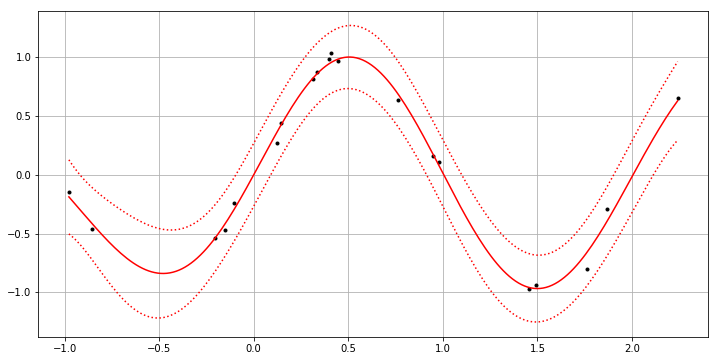

In [5]:
tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = np.random.randn(N,1)
output_data = np.sin(np.pi * input_data) + 0.05 * np.random.randn(N,1)

gp = create_gp(input_data=input_data, 
               output_data=output_data, 
               initial_signal_variance=1.0,
               initial_lengthscale=1.0,
               initial_sigma_noise_sq=1.0)

with tf.Session() as session:
    feed_dict = {}

    t_objective = gp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
    print_hyperparameters(gp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
    print_hyperparameters(gp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    plot_gp_predictions(gp, session, input_values)



## Bike Traffic Count Dataset

The following data is take from the UK Department of Transport figures counting how many cyclists crossed Vauxhall Bridge over Monday to Friday (week starting 31st July 2008). We note that the counts per hour are integers.

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,31,70,186,351,194,65,23,30,29,22,31,34,59,68,41,23,14,5,4
1,40,64,203,406,201,59,26,32,36,23,31,39,66,73,52,27,15,11,4
2,29,62,194,347,168,58,35,41,31,29,37,39,70,76,30,16,13,12,8
3,35,55,155,318,166,51,43,34,40,21,25,34,52,59,31,21,8,13,5
4,33,44,121,243,139,48,35,44,34,37,27,35,44,52,27,21,16,10,7


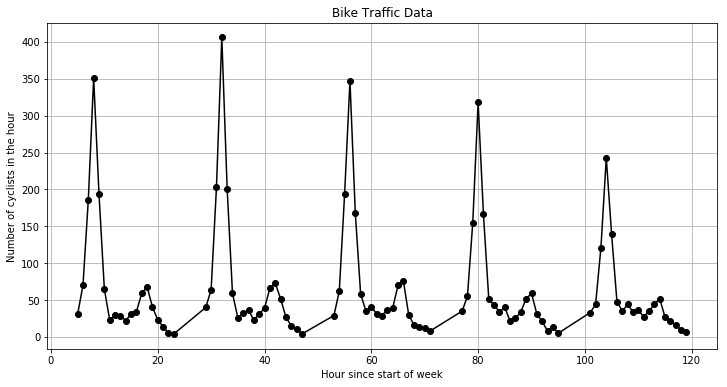

In [6]:
bike_data = pd.read_csv('traffic_data_week_2008_07_31.csv')
bike_data = bike_data.drop([5,6])
counts = bike_data.as_matrix().flatten()
times = np.zeros(bike_data.shape)
for n, r in bike_data.iterrows():
    times[n,:] = bike_data.columns.astype(np.float64) + (n*24)
times = times.flatten()

bike_counts = counts[:,np.newaxis]
bike_times = times[:,np.newaxis]

plt.figure(figsize=[12,6])
plt.plot(bike_times, bike_counts, 'ko-')
plt.grid(True)
plt.title('Bike Traffic Data')
plt.xlabel('Hour since start of week')
plt.ylabel('Number of cyclists in the hour')

bike_data

*Task:* Run the GP code with a squared exponential kernel on the bike count data. In the box below, comment on the result - how did the Gaussian GP model do?

Before Optimisation:
signal_variance = 1.0
lengthscale = 1.0
sigma_noise_squared = 1.0

  opt iter     0: objective = 170865.7284377394
  opt iter   200: objective = 1974.7006453600181
  opt iter   400: objective = 1002.7616672497223
  opt iter   600: objective = 769.091789456616
  opt iter   800: objective = 687.3504092834895
  opt iter  1000: objective = 653.8017301622575
  opt iter  1200: objective = 638.9149470729767
  opt iter  1400: objective = 632.0909944106766
  opt iter  1600: objective = 628.957637808626
  opt iter  1800: objective = 627.5484481436596
Final iter  1999: objective = 626.9384260486811

After Optimisation:
signal_variance = 162.428
lengthscale = 4.22954
sigma_noise_squared = 6687.03



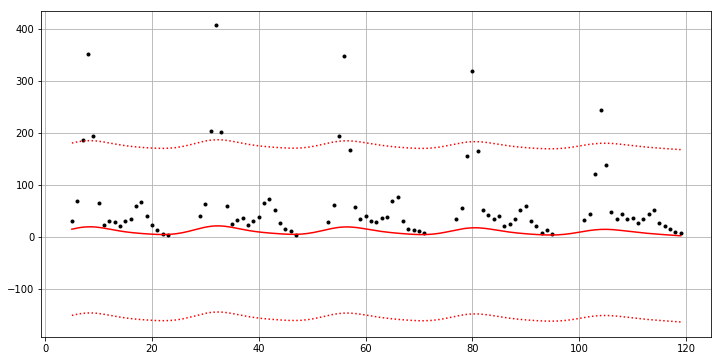

In [7]:
tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = bike_times
output_data = bike_counts

gp = create_gp(input_data=input_data, 
               output_data=output_data, 
               initial_signal_variance=1.0,
               initial_lengthscale=1.0,
               initial_sigma_noise_sq=1.0)

with tf.Session() as session:
    feed_dict = {}

    t_objective = gp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
    print_hyperparameters(gp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
    print_hyperparameters(gp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    plot_gp_predictions(gp, session, input_values)



**Type comment in box below:**

The squared exponential function is defined as
$$K_{SE} = exp\left ( -\frac{r^{2}}{2l^{2}} \right )$$
where _l_ is the lengthscale parameter.

The kernel is commonly used for modelling as it is infinitely differentiable (i.e. has mean squared derivative for all orders) and thus is very smooth. This property of SE kernel is also its drawback as such a smooth function is unrealistic for modelling any physical process. Therefore, unless there are no 'kinks' (exceptionally smooth) in the function to be model, it works absolutely fine. 

As our Bike data is highly non-smooth (with sharp peaks), the squared exponential kernel is not a suitable kernel for modelling. When we try to model our function with this kernel, either the lengthscale ends up being extremely short with posterior mean almost equal to zero at every point or the posterior mean has 'ringing' effects. Thus, we see our model to be oscillating around mean zero and it fails to extrapolate even in the smooth regions.

## Switch to using periodic kernel

*Task:* Implement the periodic kernel and copy and paste the GP code from above, modifying it to use your new periodic kernel (you will have to add a new positive parameter to represent the period $T$).

**The periodic kernel is defined as:**

$$
K(x_i, x_j) = \sigma_{\mathrm{f}}^{2} \exp\!\left( - 2 \gamma \left[\sin\left(\frac{\pi}{T} \sqrt{\|x_i - x_j\|^2} \right)\right]^2 \right)
$$

**Hyperparameters:**
- Signal variance $\sigma_{\mathrm{f}}^2$ (positive)
- Inverse Lengthscale $\gamma = 1 / \ell^2$ (positive)
- Period $T$ (positive)

In [8]:
def create_periodic_kernel(t_X1, t_X2, t_signal_variance, t_gamma, t_period):
    # Add code to this function..
    pi_inv_period = np.pi / t_period  
    
    x1x1 = tf.reduce_sum(t_X1 * t_X1, axis=1, keep_dims=True)
    x2x2 = tf.reduce_sum(t_X2 * t_X2, axis=1, keep_dims=True)
    x1x2 = 2.0 * tf.matmul(t_X1, t_X2, transpose_b=True)
    
    t_x1_x2_2 = x1x1 + tf.transpose(x2x2) - x1x2
    
    t_x1_x2_2_sqrt = tf.sqrt(t_x1_x2_2)
    
    t_sin_val_sq = tf.square(tf.sin(pi_inv_period * t_x1_x2_2_sqrt))
    
    t_exp_val = tf.exp(-2.0 * t_gamma * t_sin_val_sq) 
    
    t_K = t_signal_variance * t_exp_val
    
    return t_K

# Modify this function as appropriate..
def create_periodic_gp(input_data, 
                       output_data, 
                       initial_signal_variance,
                       initial_gamma,
                       initial_period,
                       initial_sigma_noise_sq):

    # Constant training data in tensorflow
    t_X = tf.constant(input_data, dtype=dtype)
    t_Y = tf.constant(output_data, dtype=dtype)

    t_N = tf.shape(t_Y)[0]
    t_D = tf.shape(t_Y)[1]
    t_Q = tf.shape(t_X)[1]
    jitter = 1.0e-8

    # Create variables for hyperparamers
    t_signal_variance = create_positive_variable(initial_signal_variance)
    t_gamma = create_positive_variable(initial_gamma)
    t_period = create_positive_variable(initial_period)
    t_sigma_noise_sq = create_positive_variable(initial_sigma_noise_sq)
    
    hyperparameter_dict = {'signal_variance': t_signal_variance,
                           'gamma': t_gamma,
                           'period': t_period,
                           'sigma_noise_squared': t_sigma_noise_sq}
    
    # Create a lambda function to ensure we use the same hyperparameters
    # when be create the different kernels..
    kernel_creation_function = lambda t_X1, t_X2: \
        create_periodic_kernel(t_X1=t_X1, 
                                  t_X2=t_X2,
                                  t_signal_variance=t_signal_variance,
                                  t_gamma=t_gamma,
                                  t_period=t_period)

    # Create the training data covariance matrix + noise identity matrix
    #
    # NOTE: We include the jitter term to improve nummerical stability
    #
    t_K_xx = kernel_creation_function(t_X1=t_X, t_X2=t_X) \
        + (t_sigma_noise_sq + jitter) * tf.eye(t_N, dtype=dtype)

    # Take the cholesky decomposition of K = L L^T to make it easy to calculate 
    # the inverse of K and the log determinant of K. This relies on K being a 
    # positive definite covariance matrix.
    t_L_xx = tf.cholesky(t_K_xx)

    # The log determinant of K is twice the sum of the log of the diagonal of the
    # cholesky matrix
    t_log_det = 2.0 * tf.reduce_sum(tf.log(tf.diag_part(t_L_xx)))

    # We can calculate the data fit term by using the cholesky matrix L to
    # invert the covariance matrix efficiently using the matrix triangular solve
    # operation. 
    #
    # Tr[K^-1 Y Y^T] = Tr[Y^T (L L^T)^-1 Y] = Tr[(Y^T L^-T) (L^-1 Y)] = sum((L^-1 Y)^2)
    #
    t_Kinv_YYtranspose = 0.5 * tf.reduce_sum(tf.square(
        tf.matrix_triangular_solve(t_L_xx, t_Y, lower=True)))

    # Add a loose prior on the noise variance
    t_noise_prior = + 0.5 * tf.square(tf.log(t_sigma_noise_sq))
    
    # Add loose priors on the kernel hyperparameters
    t_hyper_prior = + 0.5 * tf.square(tf.log(t_signal_variance)) \
                    + 0.5 * tf.square(tf.log(t_gamma)) \
                    + 0.5 * tf.square(tf.log(t_period))

    half_log_two_pi = tf.constant(0.5 * np.log(2.0 * np.pi), dtype=dtype)

    # Evaluate the NEGATIVE (since we will minimise) marginal log likelihood as
    # the objective for training the hyperparameters
    t_neg_log_likelihood = half_log_two_pi * dtype_convert(t_D) * dtype_convert(t_N) \
                         + 0.5 * dtype_convert(t_D) * t_log_det \
                         + t_Kinv_YYtranspose + t_hyper_prior + t_noise_prior

    def create_prediction(tf_input):
        # Invert using the cholesky decomposition of the kernel
        t_Kinv_Y = tf.cholesky_solve(t_L_xx, t_Y)
        
        # Calculate the kernel from the input to the training data
        t_K_x_X = kernel_creation_function(t_X1=tf_input, t_X2=t_X)
        
        # Get the predicitive mean
        t_y_mean = tf.matmul(t_K_x_X, t_Kinv_Y)
        
        t_K_x_x_diag = tf.diag_part(kernel_creation_function(t_X1=tf_input, t_X2=tf_input)) \
            + t_sigma_noise_sq * tf.ones([tf.shape(tf_input)[0]], dtype=dtype)

        # Get the predicitve variance
        t_y_var = t_K_x_x_diag - tf.reduce_sum(tf.square(
            tf.matrix_triangular_solve(t_L_xx, tf.transpose(t_K_x_X))), axis=0)
        
        # Make sure a N* x 1 matrix (where N* = number of test inputs)
        t_y_var = t_y_var[:, tf.newaxis]

        # Return the predicitve mean and variance
        return t_y_mean, t_y_var

    # A placeholder for providing different test data after training. See the introduction
    # to tensorflow for details on how the placeholders work
    t_prediction_placeholder = tf.placeholder(dtype=dtype)
    t_prediction_mean, t_prediction_var = create_prediction(t_prediction_placeholder)

    gp = GP(description='Periodic Gaussian Process',
            t_objective=t_neg_log_likelihood,
            create_prediction_function=create_prediction,
            t_prediction_placeholder=t_prediction_placeholder,
            t_prediction_mean=t_prediction_mean,
            t_prediction_var=t_prediction_var,
            t_input=t_X,
            t_output=t_Y,
            hyperparameter_dict=hyperparameter_dict)

    return gp

*Run the code below after writing the functions above..*

Before Optimisation:
signal_variance = 1.0
gamma = 1.0
period = 24.0
sigma_noise_squared = 1.0

  opt iter     0: objective = 136410.78567727088
  opt iter   200: objective = 1257.7561801080226
  opt iter   400: objective = 862.410426437302
  opt iter   600: objective = 702.4820208741675
  opt iter   800: objective = 621.8596067279163
  opt iter  1000: objective = 577.1817013052665
  opt iter  1200: objective = 550.8881167805054
  opt iter  1400: objective = 534.7834972817204
  opt iter  1600: objective = 524.6639594581001
  opt iter  1800: objective = 518.2110616509989
Final iter  1999: objective = 514.0875809355226

After Optimisation:
signal_variance = 3367.55
gamma = 13.7982
period = 24.0078
sigma_noise_squared = 166.431



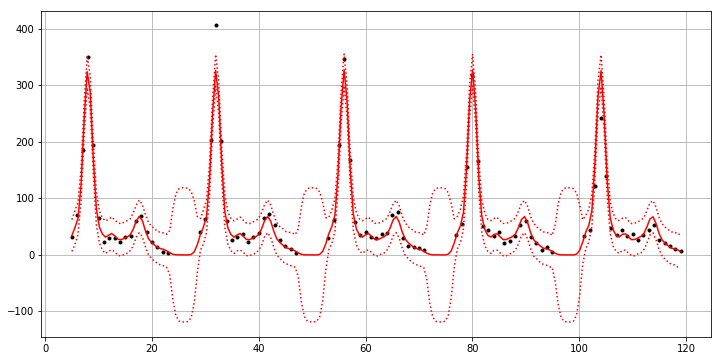

In [9]:
tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = bike_times
output_data = bike_counts

gp = create_periodic_gp(input_data=input_data, 
                        output_data=output_data, 
                        initial_signal_variance=1.0,
                        initial_gamma=1.0,
                        initial_period=24.0,
                        initial_sigma_noise_sq=1.0)

with tf.Session() as session:
    feed_dict = {}

    t_objective = gp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
    print_hyperparameters(gp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
    print_hyperparameters(gp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    plot_gp_predictions(gp, session, input_values)

#### Comment:

The situation improves after using the periodic kernel as it is suitable for the traffic data due to its periodic nature. However, we are still unable to model the sharp peaks with our predictive mean. Furthermore, the variances does not reflect the outlier points (as shown in peak no. 2) thus, completely disregarding those data points from the model results.   

## Gaussian Process Regression with Poisson Likelihood

The Poisson distribution is a probability distribution over counts within a fixed time period (positive integer values). The likelihood function is defined in terms of a positive rate parameter $\lambda > 0$ as

$$
p(y) = \frac{\lambda^{y} \exp(-\lambda)}{y!}, \; y \in [0,1,2,3,\dots]
$$

In a similar manner to the GP for binary classification (Bernoulli likelihood) in the lecture notes, we can define a GP with a Poisson likelihood

$$
p(Y, f \mid X, \theta) = p(Y \mid f) \, p(f \mid X, \theta)
$$

where the $\lambda$ parameter in the Poisson likelihood is a function of $f$. Assuming iid data we have

$$
p(Y \mid X) = \prod_{n=1}^{N} \frac{{\lambda(f_n)}^{y_n} \exp(-\lambda(f_n))}{y_n!}
$$

We put a GP prior over $f$

$$
p(f \mid X, \theta) = \mathcal{N}(f \mid 0, \kappa(X,X;\theta)
$$

however this makes the value of $f$ a real number. We map this to a positive number through the exponential function such that

$$
\lambda(f_n) = \exp(f_n) \; \Rightarrow \; \lambda(f_n) \in \mathcal{R}^{+} 
$$

To calculate the marginal log likelihood we must integrate out the function parameters $f$ such that

$$
\log p(Y \mid X, \theta) = \log \int p(Y \mid f) \, p(f \mid X, \theta) \mathrm{d}f
$$

As for the classification GP, we cannot perform this operation in closed form so we use a variational approximation 

$$
q(f) = \prod_n \mathcal{N}(f_n \mid \mu_n, \sigma^2)
$$

with a mean variational parameter $\mu_n$ for each $f_n$ and a shared variance $\sigma^2$.

The variational lower bound can then be defined as 

$$
\mathcal{L} =  \sum_n \mathbb{E}_{q(f_n)}\!\left[ \log p(y_n \mid f_n) \right] - \mathrm{KL}\big[ q(f) \,\|\, p(f\mid X, \theta) \big]
$$

We now look at the two terms in the lower bound and the next task is to derive expressions related to the expectation and the KL divergence.


## The Lower Bound for the Poisson GP

The final lower bound for the Poisson GP is therefore given by

$$
\mathcal{L} =  \sum_n \left\{ y_n \mu_n - \exp\left( \frac{2\mu_n + \sigma_n^2}{2} \right) - \log(y_n!) \right\} 
- \frac{1}{2} \left( \mathrm{Tr}[K^{-1}(\sigma^2 I + \mu \mu^T)] - N + \log \det K - N \log{\sigma^2} \right)
$$

*Task:* Update the GP code from above to optimise the negative lower bound of the Poisson GP. You will have to introduce extra TensorFlow variables for the variational parameters $\{\mu_n\}$ and $\sigma^2$. You can **initialise** the means as $\mu_n = \log(y_n)$ and the variance $\sigma^2 = 1$ (remember they are variables and not constants).

**IMPORTANT: You will also need to update the predictive posterior using the approach described in the lecture. For the purposes of plotting the result it is sufficent to evaluate the mean of $f^{*}$ and plot $\lambda(\mu_f^{*}) = \exp(\mu_{f}^{*})$ against the training data since $\lambda$ is the mean of a Poisson distribution.**

**BONUS EXTENSION: You can also derive the updated term for the predicive variance of $f^{*}$ and plot the error bars of the prediction as 
$\exp\left(\mu_f^{*} \pm 2 \sqrt{\sigma_f^{*2}}\right)$**

*Task:* Run the Poisson GP with a periodic kernel and comment on the output.

#### Negative Lower Bound Optimization using Squared Exponential Covariance Kernel

In [10]:
# A wrapper function to create a real number variable (-infinity, infinity)
# with an initial value that will be optimised by tensorflow.
def create_real_variable(initial_value):
    return tf.Variable(initial_value, dtype=dtype)

# A wrapper function to create a positive variable (0, infinity) by
# taking the exp() of a real number - this will map the real range to
# the set of positive numbers.
def create_positive_variable(initial_value):
    assert initial_value > 0.0
    return tf.exp(tf.Variable(np.log(initial_value), dtype=dtype))

# A Gaussian Process class to keep all the parts of the model we need
# grouped together
class GP:
    def __init__(self,
                 description,
                 t_objective,
                 create_prediction_function,
                 t_prediction_placeholder,
                 t_prediction_mean,
                 t_prediction_var,
                 t_input=None,
                 t_output=None,
                 hyperparameter_dict={}):

        self._description = description
        self._t_objective = t_objective
        self._create_prediction_function = create_prediction_function
        self._t_prediction_placeholder = t_prediction_placeholder
        self._t_prediction_mean = t_prediction_mean
        self._t_prediction_var = t_prediction_var
        self._t_input = t_input
        self._t_output = t_output
        self._hyperparameter_dict = hyperparameter_dict

    @property
    def description(self): return self._description

    @property
    def t_objective(self): return self._t_objective

    @property
    def t_prediction_placeholder(self): return self._t_prediction_placeholder

    @property
    def t_prediction_mean(self): return self._t_prediction_mean

    @property
    def t_prediction_var(self): return self._t_prediction_var

    @property
    def t_input(self): return self._t_input

    @property
    def t_output(self): return self._t_output

    @property
    def hyperparameter_dict(self): return self._hyperparameter_dict

    def create_prediction(self, tf_input):
        return self._create_prediction_function(tf_input)
    

# Create a GP regression model by specifying the input and output data, as (N x 1) matrices,
# and the initial values for the hyperparameters (these will be turned into tensorflow variables
# and optimised).
def create_sq_exp_cov_gp_for_lower_bound(input_data, 
                       output_data, 
                       initial_signal_variance,
                       initial_lengthscale,
                       initial_sigma_noise_sq,
                       initial_variational_mean,
                       initial_variational_variance):

    # Constant training data in tensorflow
    t_X = tf.constant(input_data, dtype=dtype)
    t_Y = tf.constant(output_data, dtype=dtype)

    t_N = tf.shape(t_Y)[0]
    t_D = tf.shape(t_Y)[1]
    t_Q = tf.shape(t_X)[1]
    jitter = 1.0e-8

    # Create variables for hyperparamers
    t_signal_variance = create_positive_variable(initial_signal_variance)
    t_lengthscale = create_positive_variable(initial_lengthscale)
    t_sigma_noise_sq = create_positive_variable(initial_sigma_noise_sq)
    t_variational_mean = create_real_variable(initial_variational_mean)
    t_variational_variance = create_positive_variable(initial_variational_variance)
    
    
    hyperparameter_dict = {'signal_variance': t_signal_variance,
                           'lengthscale': t_lengthscale,
                           'sigma_noise_squared': t_sigma_noise_sq,
                           'variational_mean': t_variational_mean,
                           'variational_variance': t_variational_variance}
    
    # Create a lambda function to ensure we use the same hyperparameters
    # when be create the different kernels..
    kernel_creation_function = lambda t_X1, t_X2: \
        create_squared_exp_kernel(t_X1=t_X1, 
                                  t_X2=t_X2,
                                  t_signal_variance=t_signal_variance,
                                  t_lengthscale=t_lengthscale)

    # Create the training data covariance matrix + noise identity matrix
    #
    # NOTE: We include the jitter term to improve nummerical stability
    #
    t_K_xx = kernel_creation_function(t_X1=t_X, t_X2=t_X) \
        + (t_sigma_noise_sq + jitter) * tf.eye(t_N, dtype=dtype)

    # Take the cholesky decomposition of K = L L^T to make it easy to calculate 
    # the inverse of K and the log determinant of K. This relies on K being a 
    # positive definite covariance matrix.
    t_L_xx = tf.cholesky(t_K_xx)

    # The log determinant of K is twice the sum of the log of the diagonal of the
    # cholesky matrix
    
    # log det K
    t_log_det = 2.0 * tf.reduce_sum(tf.log(tf.diag_part(t_L_xx)))


    # We can calculate the data fit term by using the cholesky matrix L to
    # invert the covariance matrix efficiently using the matrix triangular solve
    # operation. 
    #
    # Tr[K^-1 Y Y^T] = Tr[Y^T (L L^T)^-1 Y] = Tr[(Y^T L^-T) (L^-1 Y)] = sum((L^-1 Y)^2)
    #
    t_Kinv_YYtranspose = 0.5 * tf.reduce_sum(tf.square(
        tf.matrix_triangular_solve(t_L_xx, t_Y, lower=True)))

    # Add a loose prior on the noise variance
    t_noise_prior = + 0.5 * tf.square(tf.log(t_sigma_noise_sq))
    
    # Add loose priors on the kernel hyperparameters
    t_hyper_prior = + 0.5 * tf.square(tf.log(t_signal_variance)) \
                    + 0.5 * tf.square(tf.log(t_lengthscale)) 
                    

    half_log_two_pi = tf.constant(0.5 * np.log(2.0 * np.pi), dtype=dtype)

    # Evaluate the NEGATIVE (since we will minimise) variational lower bound as
    # the objective for training the hyperparameters
    
    # exp(---)
    t_exp = tf.exp((2 * t_variational_mean + t_variational_variance)*0.5)
    
    # First expression Summation{---}
    t_fir_expr = tf.reduce_sum(t_Y * t_variational_mean - t_exp )
    
    #Tr(---)
    t_tr_expr1= tf.reduce_sum(tf.square(tf.matrix_triangular_solve(t_L_xx, t_variational_mean, lower=True)))
    t_tr_expr2 = tf.trace(tf.cholesky_solve(t_L_xx, (t_variational_variance +jitter)* tf.eye(t_N, dtype=dtype) )) 
    
    #Second Expression 1/2(Tr(---)---)
    t_sec_expr = 0.5*(t_tr_expr1+t_tr_expr2 - dtype_convert(t_N)+ t_log_det - dtype_convert(t_N)*tf.log(t_variational_variance))
    
    #Lower Bound complete expression
    t_l_bound = -t_fir_expr + t_sec_expr
    
    

    def create_prediction(tf_input):
        # Invert using the cholesky decomposition of the kernel
        t_Kinv_Y = tf.cholesky_solve(t_L_xx, initial_variational_mean)
        
        # Calculate the kernel from the input to the training data
        t_K_x_X = kernel_creation_function(t_X1=tf_input, t_X2=t_X)
        
        # Get the predicitive mean
        t_y_mean = tf.matmul(t_K_x_X, t_Kinv_Y)
        
        t_K_x_x_diag = tf.diag_part(kernel_creation_function(t_X1=tf_input, t_X2=tf_input)) \
            + t_sigma_noise_sq * tf.ones([tf.shape(tf_input)[0]], dtype=dtype)

        # Get the predicitve variance
        t_y_var = t_K_x_x_diag - tf.reduce_sum(tf.square(
            tf.matrix_triangular_solve(t_L_xx, tf.transpose(t_K_x_X))), axis=0)
        
        # Make sure a N* x 1 matrix (where N* = number of test inputs)
        t_y_var = t_y_var[:, tf.newaxis]

        # Return the predicitve mean and variance
        return t_y_mean, t_y_var

    # A placeholder for providing different test data after training. See the introduction
    # to tensorflow for details on how the placeholders work
    t_prediction_placeholder = tf.placeholder(dtype=dtype)
    t_prediction_mean, t_prediction_var = create_prediction(t_prediction_placeholder)

    gp = GP(description='Squared Exponential Covariance Gaussian Process',
     
            t_objective=t_l_bound,
            create_prediction_function=create_prediction,
            t_prediction_placeholder=t_prediction_placeholder,
            t_prediction_mean=t_prediction_mean,
            t_prediction_var=t_prediction_var,
            t_input=t_X,
            t_output=t_Y,
            hyperparameter_dict=hyperparameter_dict)

    return gp

# Plot the predicitve posterior for the provide input values (num_test_points x 1 matrix) 
def plot_gp_predictions(gp, session, input_values):
    # Ensure N* x 1 input variable
    if input_values.ndim == 1:
        input_values = input_values[:,np.newaxis]
    
    feed_dict = {gp.t_prediction_placeholder: input_values}
    
    pred_mean, pred_var = session.run((gp.t_prediction_mean, 
                                       gp.t_prediction_var), 
                                      feed_dict=feed_dict)
    
    plt.figure(figsize=[12,6])
    plt.plot(session.run(gp.t_input), session.run(gp.t_output), 'k.')
    plt.plot(input_values, np.exp(pred_mean), 'r-')
    plt.plot(input_values, np.exp(pred_mean + 2.0*np.sqrt(pred_var)), 'r:')
    plt.plot(input_values, np.exp(pred_mean - 2.0*np.sqrt(pred_var)), 'r:')
    plt.title('Negative Lower Bound Optimization with Squared Exponential Covariance Kernel')
    plt.grid(True)

Before Optimisation:
  opt iter     0: objective = -18478.266153011256
  opt iter   200: objective = -22477.732057118432
  opt iter   400: objective = -22480.769917946276
  opt iter   600: objective = -22480.797060958834
  opt iter   800: objective = -22480.797118778468
  opt iter  1000: objective = -22480.79711879668
  opt iter  1200: objective = -22480.79711879676
  opt iter  1400: objective = -22480.79711879667
  opt iter  1600: objective = -22480.79711879667
  opt iter  1800: objective = -22480.797118796705
Final iter  1999: objective = -22480.79711879674

After Optimisation:


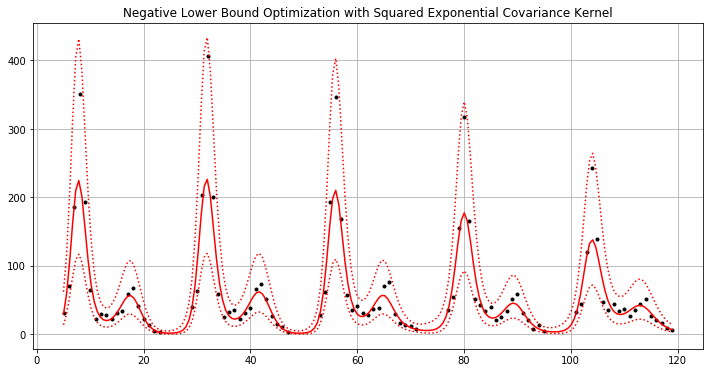

In [11]:
tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = bike_times
output_data = bike_counts
initial_variational_mean = tf.log(output_data.astype(float))

gp = create_sq_exp_cov_gp_for_lower_bound(input_data=input_data, 
               output_data=output_data, 
               initial_signal_variance=1.0,
               initial_lengthscale=1.0,
               initial_sigma_noise_sq=1.0,
               initial_variational_mean = initial_variational_mean,
               initial_variational_variance = 1.0)

with tf.Session() as session:
    feed_dict = {}

    t_objective = gp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
#     print_hyperparameters(gp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
#     print_hyperparameters(gp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    plot_gp_predictions(gp, session, input_values)



#### Negative Lower Bound Optimization using Periodic Kernel

In [12]:
#### Copy and paste GP code from above and modify it to make a Poisson GP..

# Modify this function as appropriate..

# A wrapper function to create a real number variable (-infinity, infinity)
# with an initial value that will be optimised by tensorflow.
def create_real_variable(initial_value):
    return tf.Variable(initial_value, dtype=dtype)

# A wrapper function to create a positive variable (0, infinity) by
# taking the exp() of a real number - this will map the real range to
# the set of positive numbers.
def create_positive_variable(initial_value):
    assert initial_value > 0.0
    return tf.exp(tf.Variable(np.log(initial_value), dtype=dtype))

# A Gaussian Process class to keep all the parts of the model we need
# grouped together
class GP:
    def __init__(self,
                 description,
                 t_objective,
                 create_prediction_function,
                 t_prediction_placeholder,
                 t_prediction_mean,
                 t_prediction_var,
                 t_input=None,
                 t_output=None,
                 hyperparameter_dict={}):

        self._description = description
        self._t_objective = t_objective
        self._create_prediction_function = create_prediction_function
        self._t_prediction_placeholder = t_prediction_placeholder
        self._t_prediction_mean = t_prediction_mean
        self._t_prediction_var = t_prediction_var
        self._t_input = t_input
        self._t_output = t_output
        self._hyperparameter_dict = hyperparameter_dict

    @property
    def description(self): return self._description

    @property
    def t_objective(self): return self._t_objective

    @property
    def t_prediction_placeholder(self): return self._t_prediction_placeholder

    @property
    def t_prediction_mean(self): return self._t_prediction_mean

    @property
    def t_prediction_var(self): return self._t_prediction_var

    @property
    def t_input(self): return self._t_input

    @property
    def t_output(self): return self._t_output

    @property
    def hyperparameter_dict(self): return self._hyperparameter_dict

    def create_prediction(self, tf_input):
        return self._create_prediction_function(tf_input)
    

# Create a GP regression model by specifying the input and output data, as (N x 1) matrices,
# and the initial values for the hyperparameters (these will be turned into tensorflow variables
# and optimised).
def create_periodic_gp_for_lower_bound(input_data, 
                       output_data, 
                       initial_signal_variance,
                       initial_gamma,
                       initial_period,
                       initial_sigma_noise_sq,
                       initial_variational_mean,
                       initial_variational_variance):

    # Constant training data in tensorflow
    t_X = tf.constant(input_data, dtype=dtype)
    t_Y = tf.constant(output_data, dtype=dtype)

    t_N = tf.shape(t_Y)[0]
    t_D = tf.shape(t_Y)[1]
    t_Q = tf.shape(t_X)[1]
    jitter = 1.0e-8

    # Create variables for hyperparamers
    t_signal_variance = create_positive_variable(initial_signal_variance)
    t_gamma = create_positive_variable(initial_gamma)
    t_period = create_positive_variable(initial_period)
    t_sigma_noise_sq = create_positive_variable(initial_sigma_noise_sq)
    t_variational_mean = create_real_variable(initial_variational_mean)
    t_variational_variance = create_positive_variable(initial_variational_variance)
    
    
    hyperparameter_dict = {'signal_variance': t_signal_variance,
                           'gamma': t_gamma,
                           'period': t_period,
                           'sigma_noise_squared': t_sigma_noise_sq,
                           'variational_mean': t_variational_mean,
                           'variational_variance': t_variational_variance}
    
    # Create a lambda function to ensure we use the same hyperparameters
    # when be create the different kernels..
    kernel_creation_function = lambda t_X1, t_X2: \
        create_periodic_kernel(t_X1=t_X1, 
                                  t_X2=t_X2,
                                  t_signal_variance=t_signal_variance,
                                  t_gamma=t_gamma,
                                  t_period=t_period)

    # Create the training data covariance matrix + noise identity matrix
    #
    # NOTE: We include the jitter term to improve nummerical stability
    #
    t_K_xx = kernel_creation_function(t_X1=t_X, t_X2=t_X) \
        + (t_sigma_noise_sq + jitter) * tf.eye(t_N, dtype=dtype)

    # Take the cholesky decomposition of K = L L^T to make it easy to calculate 
    # the inverse of K and the log determinant of K. This relies on K being a 
    # positive definite covariance matrix.
    t_L_xx = tf.cholesky(t_K_xx)

    # The log determinant of K is twice the sum of the log of the diagonal of the
    # cholesky matrix
    
    # log det K
    t_log_det = 2.0 * tf.reduce_sum(tf.log(tf.diag_part(t_L_xx)))


    # We can calculate the data fit term by using the cholesky matrix L to
    # invert the covariance matrix efficiently using the matrix triangular solve
    # operation. 
    #
    # Tr[K^-1 Y Y^T] = Tr[Y^T (L L^T)^-1 Y] = Tr[(Y^T L^-T) (L^-1 Y)] = sum((L^-1 Y)^2)
    #
    t_Kinv_YYtranspose = 0.5 * tf.reduce_sum(tf.square(
        tf.matrix_triangular_solve(t_L_xx, t_Y, lower=True)))

    # Add a loose prior on the noise variance
    t_noise_prior = + 0.5 * tf.square(tf.log(t_sigma_noise_sq))
    
    # Add loose priors on the kernel hyperparameters
    t_hyper_prior = + 0.5 * tf.square(tf.log(t_signal_variance)) \
                    + 0.5 * tf.square(tf.log(t_gamma)) \
                    + 0.5 * tf.square(tf.log(t_period))

    half_log_two_pi = tf.constant(0.5 * np.log(2.0 * np.pi), dtype=dtype)

    # Evaluate the NEGATIVE (since we will minimise) variational lower bound as
    # the objective for training the hyperparameters
    
    # exp(---)
    t_exp = tf.exp((2 * t_variational_mean + t_variational_variance)*0.5)
    
    # First expression Summation{---}
    t_fir_expr = tf.reduce_sum(t_Y * t_variational_mean - t_exp )
    
    #Tr(---)
    t_tr_expr1= tf.reduce_sum(tf.square(tf.matrix_triangular_solve(t_L_xx, t_variational_mean, lower=True)))
    t_tr_expr2 = tf.trace(tf.cholesky_solve(t_L_xx, (t_variational_variance +jitter)* tf.eye(t_N, dtype=dtype) )) 
    
    #Second Expression 1/2(Tr(---)---)
    t_sec_expr = 0.5*(t_tr_expr1+t_tr_expr2 - dtype_convert(t_N)+ t_log_det - dtype_convert(t_N)*tf.log(t_variational_variance))
    
    #Lower Bound complete expression
    t_l_bound = -t_fir_expr + t_sec_expr
    
    

    def create_prediction(tf_input):
        # Invert using the cholesky decomposition of the kernel
        t_Kinv_Y = tf.cholesky_solve(t_L_xx, initial_variational_mean)
        
        # Calculate the kernel from the input to the training data
        t_K_x_X = kernel_creation_function(t_X1=tf_input, t_X2=t_X)
        
        # Get the predicitive mean
        t_y_mean = tf.matmul(t_K_x_X, t_Kinv_Y)
        
        t_K_x_x_diag = tf.diag_part(kernel_creation_function(t_X1=tf_input, t_X2=tf_input)) \
            + t_sigma_noise_sq * tf.ones([tf.shape(tf_input)[0]], dtype=dtype)

        # Get the predicitve variance
        t_y_var = t_K_x_x_diag - tf.reduce_sum(tf.square(
            tf.matrix_triangular_solve(t_L_xx, tf.transpose(t_K_x_X))), axis=0)
        
        # Make sure a N* x 1 matrix (where N* = number of test inputs)
        t_y_var = t_y_var[:, tf.newaxis]

        # Return the predicitve mean and variance
        return t_y_mean, t_y_var

    # A placeholder for providing different test data after training. See the introduction
    # to tensorflow for details on how the placeholders work
    t_prediction_placeholder = tf.placeholder(dtype=dtype)
    t_prediction_mean, t_prediction_var = create_prediction(t_prediction_placeholder)

    gp = GP(description='Periodic Gaussian Process',
     
            t_objective=t_l_bound,
            create_prediction_function=create_prediction,
            t_prediction_placeholder=t_prediction_placeholder,
            t_prediction_mean=t_prediction_mean,
            t_prediction_var=t_prediction_var,
            t_input=t_X,
            t_output=t_Y,
            hyperparameter_dict=hyperparameter_dict)

    return gp

# Plot the predicitve posterior for the provide input values (num_test_points x 1 matrix) 
def plot_gp_predictions(gp, session, input_values):
    # Ensure N* x 1 input variable
    if input_values.ndim == 1:
        input_values = input_values[:,np.newaxis]
    
    feed_dict = {gp.t_prediction_placeholder: input_values}
    
    pred_mean, pred_var = session.run((gp.t_prediction_mean, 
                                       gp.t_prediction_var), 
                                      feed_dict=feed_dict)
    
    plt.figure(figsize=[12,6])
    plt.plot(session.run(gp.t_input), session.run(gp.t_output), 'k.')
    plt.plot(input_values, np.exp(pred_mean), 'r-')
    plt.plot(input_values, np.exp(pred_mean + 2.0*np.sqrt(pred_var)), 'r:')
    plt.plot(input_values, np.exp(pred_mean - 2.0*np.sqrt(pred_var)), 'r:')
    plt.title('Negative Lower Bound Optimization with Periodic Kernel')
    plt.grid(True)

Before Optimisation:
  opt iter     0: objective = -18661.565653156944
  opt iter   200: objective = -22555.149881200756
  opt iter   400: objective = -22543.2441170751
  opt iter   600: objective = -22573.241151741433
  opt iter   800: objective = -22573.27540850449
  opt iter  1000: objective = -22575.590623379292
  opt iter  1200: objective = -22569.30005212919
  opt iter  1400: objective = -22575.41703638248
  opt iter  1600: objective = -22497.923568376205
  opt iter  1800: objective = -22572.214959063178
Final iter  1999: objective = -22573.800335129625

After Optimisation:


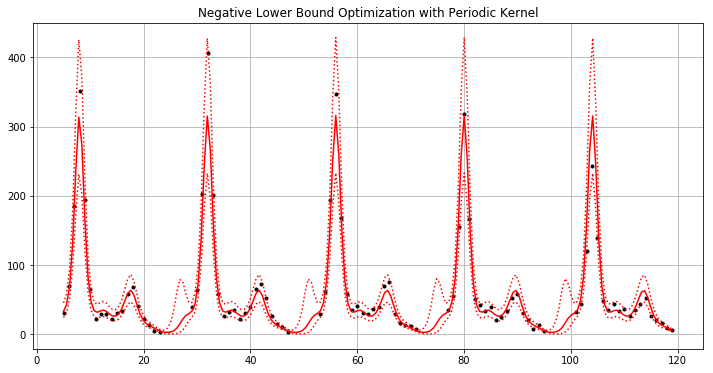

In [13]:
tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = bike_times
output_data = bike_counts
initial_variational_mean = tf.log(output_data.astype(float))
# print(initial_variational_mean)


gp = create_periodic_gp_for_lower_bound(input_data=input_data, 
                        output_data=output_data, 
                        initial_signal_variance=1.0,
                        initial_gamma=1.0,
                        initial_period=24.0,
                        initial_sigma_noise_sq=1.0,
                        initial_variational_mean = initial_variational_mean,
                        initial_variational_variance = 1.0)

with tf.Session() as session:
    feed_dict = {}

    t_objective = gp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
#     print_hyperparameters(gp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
#     print_hyperparameters(gp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    plot_gp_predictions(gp, session, input_values)

**Comments in the Markdown box below..**

The variational lower bound performs leaps and bounds better than our previous models (which uses Gaussian prior suitable for continuous data) as it uses poission as prior which is used for modelling counts. 

Also, from the above results we observe that the Periodic Kernel performs better at optimization as compared to the SE Kernel which is an expected result as the data to be modelled is not a smooth function. Furthermore, the periodic kernel is suitable for data which repeats itself which is true in our bike data thus, providing it a two-fold advantage over SE kernel. 

If we observe the error bars for our two kernels, we see that the ones for the periodic kernel are much smaller which suggests that the variance is comparatively lower. Thus. proving to be a better overall predictor for our bike data. 